In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-06-17 19:50:04--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-06-17 19:50:04 (31.5 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [ ]:
from fenics import *

In [ ]:
# N-S cavity problem

n = 15
mesh = UnitSquareMesh(n, n, 'crossed')

V = VectorElement('P', mesh.ufl_cell(), 2)
Q = FiniteElement('P', mesh.ufl_cell(), 1)

X = FunctionSpace(mesh, MixedElement([V, Q]))

#Boundary Conditions
g_D = Expression(('near(x[1], 1) ? -2 : 0', '0'), degree=3)

def boundary(x, on_boundary):
    return on_boundary

bc_u = DirichletBC(X.sub(0), g_D, boundary) #1.si defined on the entire mesh 2.si which funtion to be enforced 3.sü where

def origin(x, on_boundary):
    return near(x[0], 0) and near(x[1], 0)

bc_p = DirichletBC(X.sub(1), Constant(0.), origin, 'pointwise')

bc = [bc_u, bc_p]

Re = 500
f = Constant((0., 0.))


def newton_step(X, u_old, Re, bc, f):
    u, p = TrialFunctions(X)
    v, q = TestFunctions(X)

# It would be more efficient to build all matrices that remain the same
# at all steps outside the loop, and update only the ones containing u_old
    a = (dot(dot(grad(u), u_old) , v) * dx
         + dot(dot(grad(u_old), u) ,v) * dx
         - p * div(v) *dx
         + 1/Re* inner(grad(u), grad(v)) * dx
         + q * div(u) * dx)

    L = dot((dot(grad(u_old), u_old) + f), v ) * dx

    x = Function(X)  #solution
    solve(a==L, x, bc) #providing list of boundary conditions

    u, p = x.split()

    return u, p

#define initial guess and time step
#for reynolds initial guess is zero

#u0 = Constant(('0.', '0.'))
#u0 = project(u0, VectorFunctionSpace(mesh, 'P', 2))

#u0 = u_newton
u0 = project(u, VectorFunctionSpace(mesh, 'P', 2))

maxiter = 50
tol = 1e-6
u, p = newton_step(X, u0, Re, bc, f)

for i in range(maxiter):
    u_old = u
    p_old = p
    u, p = newton_step(X, u_old, Re, bc, f)
    error = (errornorm(u, u_old, 'H1') / norm(u_old, 'H1') +
    errornorm(p, p_old, 'L2') / norm(p_old, 'L2'))

    print('iteration ', i)
    print('error = ', error)

    if error<tol:
        break

    u_newton = u

Calling FFC just-in-time (JIT) compiler, this may take some time.
iteration  0
error =  1.1318065397642594
iteration  1
error =  1.3062409438042328
iteration  2
error =  0.6400595000275638
iteration  3
error =  0.3422618903971022
iteration  4
error =  0.04806143414040756
iteration  5
error =  0.0008538162797559045
iteration  6
error =  1.3361550191461534e-06
iteration  7
error =  2.022419828717895e-12


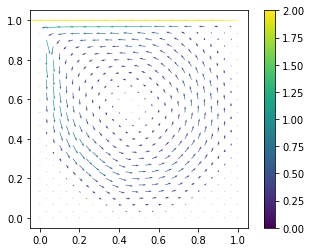

In [ ]:
import matplotlib.pyplot as plt

q = plot(u)
plt.colorbar(q)

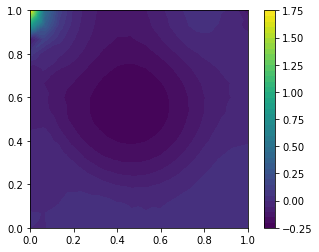

In [ ]:
q = plot(p)
plt.colorbar(q)